In [1]:
!date

Wed Apr 24 10:16:48 PDT 2024


In [2]:
%load_ext autoreload
%load_ext line_profiler

In [3]:
import os as _os
_os.chdir(_os.environ['PROJECT_ROOT'])

In [4]:
import strainzip as sz
import graph_tool as gt
import graph_tool.draw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from contextlib import contextmanager
import xarray as xr
from itertools import product
from tqdm import tqdm
from itertools import chain
from strainzip.pandas_util import idxwhere
from graph_tool.util import find_edge
import scipy as sp

In [5]:
# Plotting parameters

length_bins = np.logspace(0, 6.5, num=51)
depth_bins = np.logspace(-1, 4, num=51)

draw_graphs = True
run_number = 21  # Label for output files/figures

In [46]:
group = 'xjin_test6'

with open(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat.fn') as f:
    _, unitig_to_sequence = sz.io.load_graph_and_sequences_from_linked_fasta(f, 111, sz.io.ggcat_header_tokenizer)

In [47]:
final_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat.notips.deconvolve-10.sz')
final_results = sz.results.extract_vertex_data(final_graph).assign(assembly=lambda d: d.segments.apply(sz.results.assemble_overlapping_unitigs, unitig_to_sequence=unitig_to_sequence, k=final_graph.gp['kmer_length']))
# final_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat.notips.deconvolve-20.deconvolve-10.sz')
# final_results = sz.results.extract_vertex_data(final_graph).assign(assembly=lambda d: d.segments.apply(sz.results.assemble_overlapping_unitigs, unitig_to_sequence=unitig_to_sequence, k=final_graph.gp['kmer_length']))

original_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat.notips-unpressed.sz')
original_results = sz.results.extract_vertex_data(original_graph)
nounzip_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat.notips.sz')
nounzip_results = sz.results.extract_vertex_data(nounzip_graph)
# onepass_graph = sz.io.load_graph(f'data/group/{group}/r.proc.kmtricks-k111-m3-r2.ggcat.notips.deconvolve-10.sz')
# onepass_results = sz.results.extract_vertex_data(final_graph).assign(assembly=lambda d: d.segments.apply(sz.results.assemble_overlapping_unitigs, unitig_to_sequence=unitig_to_sequence, k=final_graph.gp['kmer_length']))

95.3845520387743
277.26766244196165
288.22408134716125


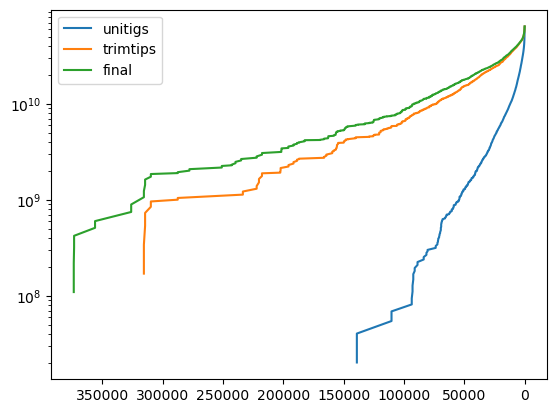

In [92]:
# Overall, we get about 2x as much long sequence depth (distribution of tig lengths of assigned kmers)

fig, ax = plt.subplots()

for _label, (_graph, _results) in {
    'unitigs': (original_graph, original_results),
    'trimtips': (nounzip_graph, nounzip_results),
    # 'onepass': (onepass_graph, onepass_results),
    'final': (final_graph, final_results)
}.items():
    d = _results.sort_values('length', ascending=False).assign(length_x_depth=lambda x: x.total_depth * x.length, length_x_depth_cumsum=lambda x: x.length_x_depth.cumsum())
    ax.plot(d.length, d.length_x_depth_cumsum, label=_label)
    print(sz.stats.depth_weighted_mean_tig_length(_graph))

ax.set_yscale('log')
# ax.set_xscale('log')

ax.legend()
ax.invert_xaxis()

In [93]:
final_results.sort_values(['length'], ascending=False).head(20)

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,length_x_depth,assembly
vertex,,,,,,,,,,
233172,(144170),(100621),373580,293.983101,"(1531121-, 1633624-, 216886+, 1633635+, 185668...",333,1,1,1.098262e+08,TTATGGCTTGAAGGTAACACCCGTTCCCATGCCGAACACGAAGGTT...
233132,(92343),(60401),373580,293.983108,"(2004821-, 1034349+, 1034476+, 1034495-, 10342...",333,1,1,1.098262e+08,ACTCTATACTCTATACTCTATACTCTATACTCTATACTCTATACTC...
232964,(144170),(100621),373308,272.389814,"(1531121-, 1633624-, 216886+, 1633635+, 185668...",334,1,1,1.016853e+08,TTATGGCTTGAAGGTAACACCCGTTCCCATGCCGAACACGAAGGTT...
232588,(92343),(60401),373308,272.389820,"(2004821-, 1034349+, 1034476+, 1034495-, 10342...",334,1,1,1.016853e+08,ACTCTATACTCTATACTCTATACTCTATACTCTATACTCTATACTC...
234366,(84315),(35547),355952,250.854485,"(2153818+, 2131987+, 2132002-, 2164339-, 12133...",295,1,1,8.929216e+07,AAAATGTATCTATAAATAAATCTACACATTCTTCCAAATATTCTTC...
234367,(7736),(51767),355952,250.854485,"(1219538+, 2019701-, 2318394-, 1858698-, 16236...",295,1,1,8.929216e+07,TTATGGCTTGAAGGTAACACCCGTTCCCATGCCGAACACGAAGGTT...
233665,(85844),(),326008,452.543250,"(2169713+, 2199586+, 2294212+, 2167464-, 22342...",50,1,0,1.475327e+08,GTTCCCATACCGAACACAGTAGTTAAGCATTCAGAGGCCGAAAGTA...
233496,(),(159128),326008,452.543250,"(2179805-, 2179806-, 1563635-, 2053470+, 20591...",50,0,1,1.475327e+08,AGCGGCGGCAGCGACTACTCCATCCCCCTGCTCCAGCACGCCGGCG...
187035,(),"(224260, 226621)",315487,541.842570,"(1446196+, 2143947+, 2143948-, 1776792-, 14612...",73,0,2,1.709443e+08,CACGCATGCGCCCCCTTCTCTTCATCATCTGCACGTTCTGCCCCAT...


In [97]:
final_results.segments.explode().value_counts().head(20)

segments
946647+     8
946647-     8
1348461+    7
1920285+    7
1348461-    7
1920285-    7
2073902+    6
1781392-    6
2123996+    6
1873040-    6
1872962-    6
2099606-    6
2313822+    6
2157633+    6
2003728-    6
1503504+    6
421373-     6
2003631+    6
1788557-    6
1788563+    6
Name: count, dtype: int64

In [52]:
unitig_depth_table = sz.results.full_depth_table(original_graph).rename(original_results.segments.str[0])
unitig_depth_table.shape

(403470, 66)

In [98]:
# Use this to find tigs of interest.

final_results.loc[sz.results.iter_find_vertices_with_any_segment(final_graph, ['421373-'])]

,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,length_x_depth,assembly
vertex,,,,,,,,,,
234396,(),(37463),83557,133.739694,"(257374+, 257330+, 257351-, 257395-, 257313+, ...",83,0,1,1.117489e+07,ATTAAATATTAACGACTGTAGCGGCTACTAGAGCTATGCTAGAGGC...
234406,(),(37463),83572,132.537990,"(257321+, 257330+, 257351-, 257395-, 257313+, ...",83,0,1,1.107646e+07,AAATAAAAATGTGGGATGAAATATTAACGACTGTAGCGGCTACTAG...
234517,"(7529, 230043)",(37463),83572,69.890488,"(257322+, 257339-, 257382+, 257326+, 257351-, ...",85,2,1,5.840888e+06,AAATAAAAATGTGGGATGAAAGATTAACGACTGTAGCGGCTACTAG...
234518,(),(37463),83572,66.114973,"(257317+, 257339-, 257382+, 257326+, 257351-, ...",85,0,1,5.525360e+06,AAATAAAATTGTGGGATGAAAGATTAACGACTGTAGCGGCTACTAG...
234519,(),(37463),83572,66.172139,"(257318+, 257375+, 257326+, 257351-, 257395-, ...",84,0,1,5.530138e+06,AAATAAAAATGTGGTATTAAAGATTAACGACTGTAGCGGCTACTAG...
234522,(),(37463),83572,66.897063,"(257320+, 257375+, 257326+, 257351-, 257395-, ...",84,0,1,5.590721e+06,AAATAAAAATGTGGGATTAAAGATTAACGACTGTAGCGGCTACTAG...


In [99]:
focal_path = 234517
radius = 1000

related_paths = list(sz.results.iter_find_vertices_with_any_segment(final_graph, final_results.loc[focal_path].segments))
print(len(related_paths))
focal_segments = list(set(chain(*final_results.loc[related_paths].segments)))

original_graph_core_vertices = list(sz.results.iter_find_vertices_with_any_segment(original_graph, focal_segments))
original_graph_distance_to_core = sz.topology.get_shortest_distance(original_graph, original_graph_core_vertices, original_graph.vp['length'])
in_neighborhood = original_graph.new_vertex_property('bool', vals=original_graph_distance_to_core.a < radius)

neighborhood_graph = gt.GraphView(original_graph, vfilt=in_neighborhood)
print(neighborhood_graph)

outpath = f'fig/run-{run_number}/final_paths.neighborhood-{focal_path}.fn'
with open(outpath, 'w') as f:
    for path, d1 in final_results.loc[related_paths].iterrows():
        print(f">{path}\n{d1.assembly}", file=f)
print(outpath)

7
<GraphView object, directed, with 100 vertices and 99 edges, 4 internal vertex properties, 2 internal graph properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x171f10770, at 0x172ecd670>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x171f10770, at 0x1912a2b70>, False), at 0x171f10770>
fig/run-21/final_paths.neighborhood-234517.fn


In [100]:
sz.draw.update_xypositions(neighborhood_graph)

vertex_color = neighborhood_graph.new_vertex_property('float', vals=sz.results.total_depth_property(neighborhood_graph).a**(1/2))

for path in related_paths:
    original_graph_vertices = list(sz.results.iter_find_vertices_with_any_segment(original_graph, final_results.loc[path].segments))
    print(len(original_graph_vertices))
    in_path = original_graph.new_vertex_property('bool', val=False)
    in_path.a[original_graph_vertices] = 1
    outpath = f'fig/run-{run_number}/final_paths.neighborhood-{focal_path}-{path}.pdf'
    sz.draw.draw_graph(
        neighborhood_graph,
        vertex_text=neighborhood_graph.vp['sequence'],
        vertex_halo=in_path,
        vertex_font_size=5,
        vertex_fill_color=vertex_color,
        output=outpath,
        vcmap=(mpl.cm.magma, 1),
        output_size=(1000, 1000),
    )
    print(outpath)

final_results.loc[related_paths]

1
fig/run-21/final_paths.neighborhood-234517-216138.pdf
83
fig/run-21/final_paths.neighborhood-234517-234396.pdf
83
fig/run-21/final_paths.neighborhood-234517-234406.pdf
85
fig/run-21/final_paths.neighborhood-234517-234517.pdf
85
fig/run-21/final_paths.neighborhood-234517-234518.pdf
84
fig/run-21/final_paths.neighborhood-234517-234519.pdf
84
fig/run-21/final_paths.neighborhood-234517-234522.pdf


,in_neighbors,out_neighbors,length,total_depth,segments,num_segments,num_in_neighbors,num_out_neighbors,length_x_depth,assembly
vertex,,,,,,,,,,
216138,"(216802, 233514)","(230043, 217589)",3,542.413726,"(1348461-,)",1,2,2,1.627241e+03,TAAATTGCATTCAAAACTATTTGCGTTAGCAAACAAATTTAATATA...
234396,(),(37463),83557,133.739694,"(257374+, 257330+, 257351-, 257395-, 257313+, ...",83,0,1,1.117489e+07,ATTAAATATTAACGACTGTAGCGGCTACTAGAGCTATGCTAGAGGC...
234406,(),(37463),83572,132.537990,"(257321+, 257330+, 257351-, 257395-, 257313+, ...",83,0,1,1.107646e+07,AAATAAAAATGTGGGATGAAATATTAACGACTGTAGCGGCTACTAG...
234517,"(7529, 230043)",(37463),83572,69.890488,"(257322+, 257339-, 257382+, 257326+, 257351-, ...",85,2,1,5.840888e+06,AAATAAAAATGTGGGATGAAAGATTAACGACTGTAGCGGCTACTAG...
234518,(),(37463),83572,66.114973,"(257317+, 257339-, 257382+, 257326+, 257351-, ...",85,0,1,5.525360e+06,AAATAAAATTGTGGGATGAAAGATTAACGACTGTAGCGGCTACTAG...
234519,(),(37463),83572,66.172139,"(257318+, 257375+, 257326+, 257351-, 257395-, ...",84,0,1,5.530138e+06,AAATAAAAATGTGGTATTAAAGATTAACGACTGTAGCGGCTACTAG...
234522,(),(37463),83572,66.897063,"(257320+, 257375+, 257326+, 257351-, 257395-, ...",84,0,1,5.590721e+06,AAATAAAAATGTGGGATTAAAGATTAACGACTGTAGCGGCTACTAG...


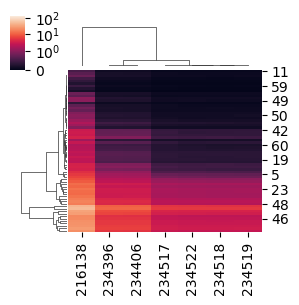

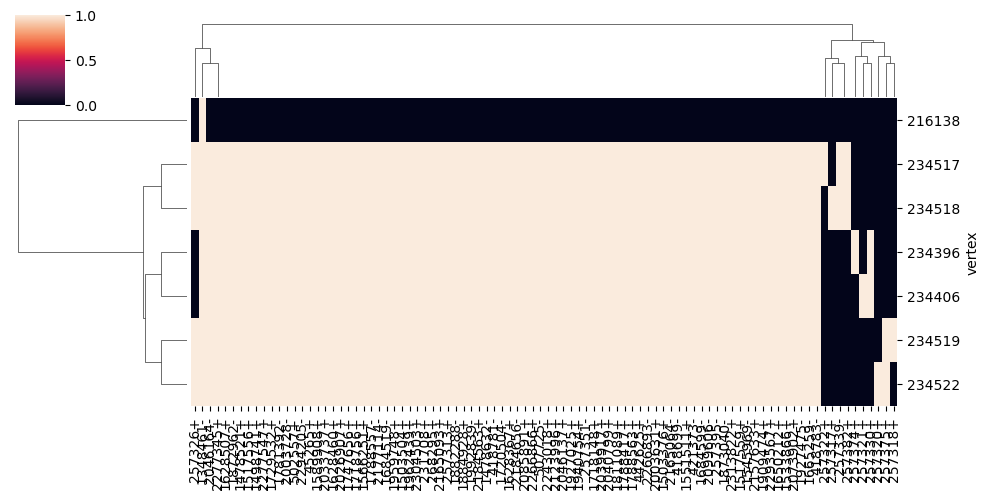

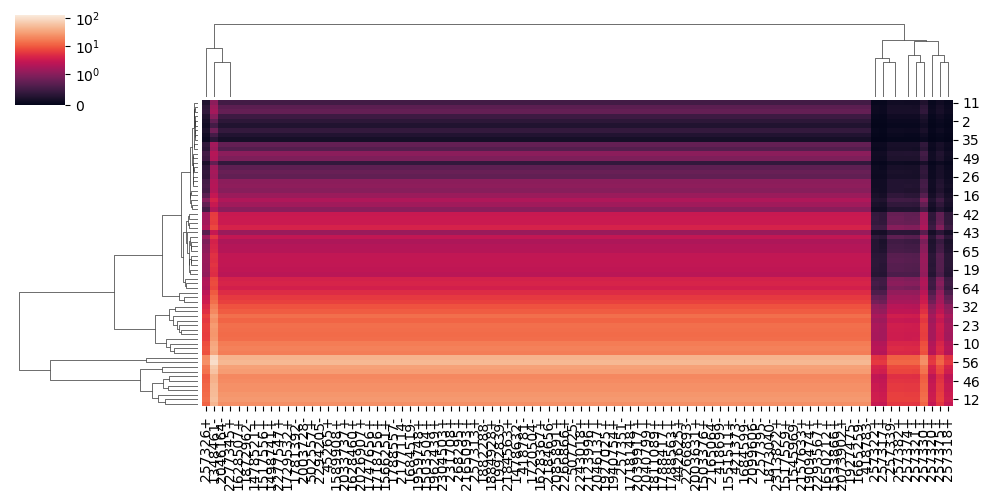

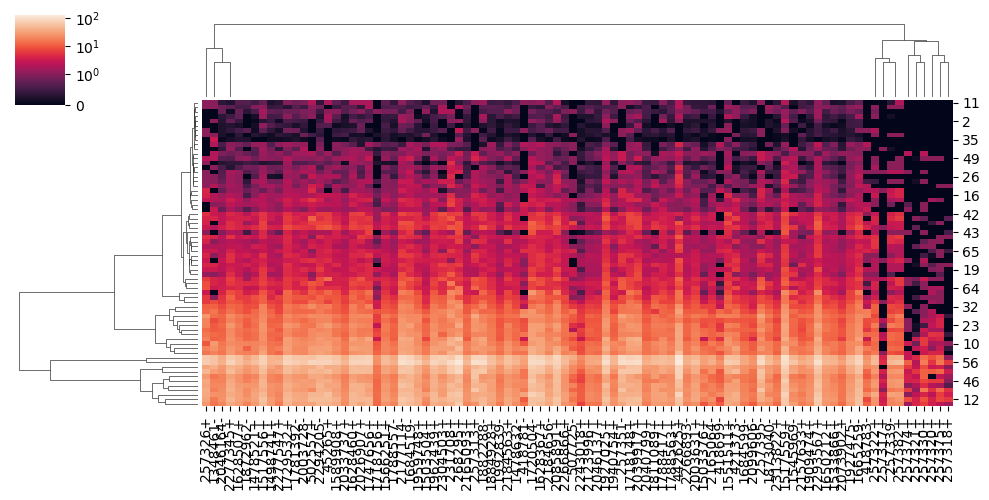

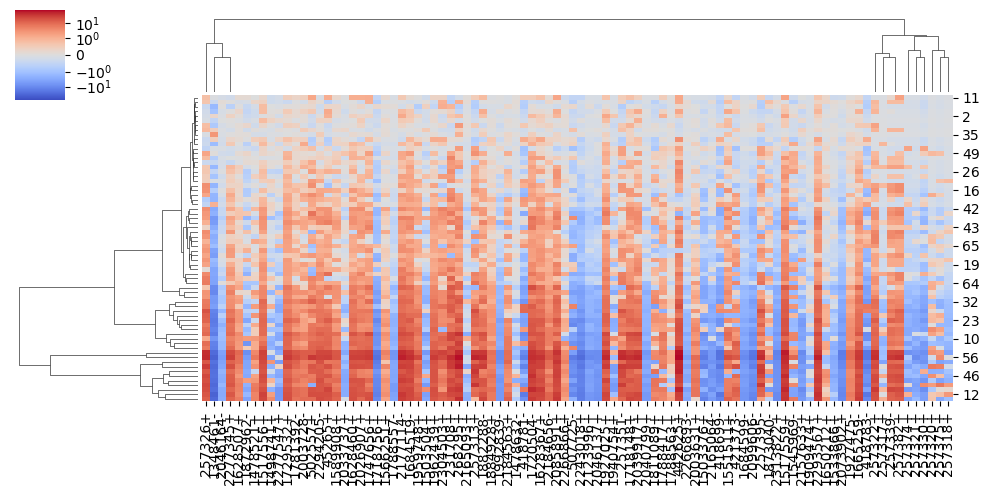

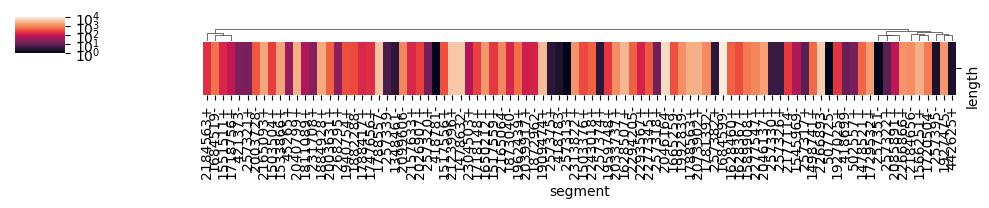

In [101]:
unitig_depth = unitig_depth_table.loc[focal_segments].T
path_membership = final_results.loc[related_paths].segments.explode().reset_index().value_counts().unstack(fill_value=0)
path_depth = pd.DataFrame({p: final_graph.vp['depth'][p] for p in related_paths})
predicted_unitig_depth = path_depth @ path_membership

unitig_length = original_results.loc[original_graph_core_vertices].assign(segment=lambda x: x.segments.str[0]).set_index('segment')[['length']]

obs = unitig_depth
expect = predicted_unitig_depth.loc[obs.index, obs.columns]
membership = path_membership.loc[:,obs.columns]
resid = obs - expect
estimate = path_depth

unitig_linkage = sp.cluster.hierarchy.linkage(membership.T, metric='euclidean', method='average')
path_linkage = sp.cluster.hierarchy.linkage(membership, metric='euclidean', method='average')
sample_linkage = sp.cluster.hierarchy.linkage(obs, metric='euclidean', method='average')
# segment_color = mpl.cm.viridis(segment_length)

max_obs = obs.max().max()
max_resid = resid.max().max()

sns.clustermap(estimate, row_linkage=sample_linkage, figsize=(3, 3), norm=mpl.colors.SymLogNorm(1, vmin=0, vmax=max_obs))
sns.clustermap(membership, row_linkage=path_linkage, col_linkage=unitig_linkage, figsize=(10, 5), xticklabels=1)
sns.clustermap(expect, row_linkage=sample_linkage, col_linkage=unitig_linkage, figsize=(10, 5), norm=mpl.colors.SymLogNorm(1, vmin=0, vmax=max_obs), xticklabels=1)
sns.clustermap(obs, row_linkage=sample_linkage, col_linkage=unitig_linkage, figsize=(10, 5), norm=mpl.colors.SymLogNorm(1, vmin=0, vmax=max_obs), xticklabels=1)
sns.clustermap(resid, row_linkage=sample_linkage, col_linkage=unitig_linkage, figsize=(10, 5), norm=mpl.colors.SymLogNorm(1, vmin=-max_resid, vmax=max_resid), cmap='coolwarm', xticklabels=1)
sns.clustermap(unitig_length.T, row_cluster=False, col_linkage=unitig_linkage, figsize=(10, 2), xticklabels=1, norm=mpl.colors.SymLogNorm(1))